## Laboratorium 8.1


## Metody wykrywania ruchu: przepływ optyczny (_optical flow_)

### Wstęp

Na poprzednich laboratoriach poznaliśmy podstawowe metody przetwarzania obrazów, a więc dwuwymiarowych sygnałów przestrzennych. Wiele z tych metod działa także dla (trójwymiarowego) sygnału wideo, jeśli - nieco naiwnie - potraktujemy go jako po prostu sekwencję niezależnych obrazów.

W tej liście wykorzystasz także dziedziną czasową do przetwarzania sygnału. Podstawowa intuicja polega na tym, że jeśli jakiś rejon obrazu przesunął się w czasie, to prawdopodobnie ma on inne _znaczenie_ niż rejon, który pozostał w tym samym miejscu, lub przesunął w innym kierunku czy z inną szybkością. Jeśli zatem jesteśmy w stanie wykryć to przesunięcie - czyli po prostu _ruch_ - to otrzymamy pewną informację o zawartości obrazu (wideo). Na przykład, będziemy w stanie oddzielić poruszające się obiekty od stacjonarnego tła, albo oddzielić inaczej poruszające się obiekty.

Jedną z najpowszechniejszych metodą do automatycznej detekcji ruchu jest znana Ci już z wykładu metoda przepływu optycznego (ang. _optical flow_). Namawiam też do lektury [artykułu z dokumentacji OpenCV](https://docs.opencv.org/3.4/d4/dee/tutorial_optical_flow.html), zwłaszcza sekcji _Lucas-Kanade_ oraz _Dense Optical Flow_. Analizując kod metody, poświęć chwilę na zrozumienie mapowania wyników do prezentowanego obrazu w przestrzeni HSV.

Wiedzieć należy na pewno, że istnieją dwie główne odmiany metody przepływu optycznego:,
* przepływ gęsty (_dense_) - gdzie przesunięcie pomiędzy klatkami określane jest dla każdego piksela (na tej metodzie skupia się niniejsza część listy),
* przepływ rzadki (_sparse_) - gdzie ruch wykrywany jest tylko dla pewnego zbioru punktów zainteresowania w obrębie obrazu (przebadasz ją w drugiej części listy).

W ramach obu odmian występuje pewna liczba konkretnych metod obliczeniowych, w zależności od konkretnego podejścia do rozwiązywania równania ruchu. Na tych zajęciach wykorzystamy [algorytm Farnebacka](http://www.diva-portal.org/smash/get/diva2:273847/FULLTEXT01.pdf) - głównie dlatego, że jego gotowa implementacja znajduje się w pakiecie OpenCV.

### Podejście

Większość algorytmów optical flow operuje na parze klatek, znajdując wektory translacji pomiędzy rejonami z jednej i drugiej. Jeśli więc interesuje nas przetwarzanie ciągłego strumienia wideo, praca przebiegać będzie na zasadzie dwuelementowej kolejki, tzn. zawsze patrzymy na klatkę obecną $I(x,y,t)$ i poprzednią $I(x,y,t-1)$.

OpenCV oferuje banalnie prosty a zarazem potężny interfejs do obsługi strumieni wideo: [`cv2.VideoCapture`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html), za pomocą którego w ten sam sposób możemy obsługiwać pliki wideo w różnym kodowaniu, urządzenia wideo (np. kamerkę w laptopie) czy nawet wideo w protokole IP (choć występują pewne różnice z punktu widzenia użycia, jeśli korzystamy z zasobu sprzętowego działającego w czasie rzeczywistym). Idea jest prosta:
* tworzymy obiekt `cv2.VideoCapture` w odpowiedni sposób,
* pobieramy poszczególne klatki za pomocą metody [`VideoCapture::read`](https://docs.opencv.org/3.4/d8/dfe/classcv_1_1VideoCapture.html#a473055e77dd7faa4d26d686226b292c1).

Metoda `read` wykonuje całą pracę (odczytanie danych, dekodowanie strumienia wideo) i zwraca klatkę jako obraz w standardowym formacie OpenCV (a także flagę, czy w ogóle udało się pozyskać dane - krotka (flaga, klatka)). Zatem, aby pozyskać pierwszą klatkę z pliku wideo wystarczy:
```python
vid = cv2.VideoCapture("back.mp4")
r, frame = vid.read()
```

Drobnym ograniczeniem VideoCapture jest to, że nie ma możliwości cofnięcia się do poprzednio pobranej klatki (co jest naturalne w przypadku korzystania z fizycznego urządzenia do akwizycji, a może trochę mniej gdy czytamy z pliku). Jeśli potrzebny jest powrót do początku pliku wideo, niestety konieczne jest zamknięcie strumienia (`VideoCapture::release`) i ponowne otwarcie (`::open`).

Aby obliczyć (gęsty) przepływ optyczny pomiędzy dwiema klatkami, wykorzystamy algorytm Farnebacka, zaimplementowany w OpenCV w funkcji [`cv2.calcOpticalFlowFarneback`](https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga5d10ebbd59fe09c5f650289ec0ece5af). Przyjmuje ona parę obrazów **w skali szarości**, opcjonalny argument `flow` (rozwiązanie można zainicjować poprzednio wyliczonym przepływem, jeśli nim dysponujemy), a następnie szereg parametrów sterujących metodą; m.in. można wykorzystać piramidyzację obrazów (rekomendowane `pyr_size` $=3$) czy określić rozmiar okna detekcji `winsize`. Sensowne pierwsze wartości dla argumentów podane są w dokumentacji.

Algorytm Farnebacka zwraca przepływ w formie obrazu o wymiarach przestrzennych równych obrazom wejściowym i dwóch kanałach, zawierających przesunięcie odpowiednio w osi $x$ i $y$. Można więc przetwarzać te dane dalej, np. obliczając kąt przesunięcia czy całkowitą odległość (i dalej, np. określić prędkość ruchu) - vide np. `cv2.cartToPolar`.

---

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### Zadanie 1

#### Zadanie 1a
Otwórz wideo `kick.mp4` lub `back.mp4` i pobierz kilka klatek. Przewiń do interesującego Cię momentu - tak, aby uzyskać dwie klatki, na których widać ruch (pro-tip: znając framerate materiału (~25fps) i czas, w którym rozpoczyna się interesujący fragment, możesz w pętli "skonsumować" odpowiednią ilość klatek).  
Wykorzystaj algorytm Farnebacka do obliczenia przepływu pomiędzy klatkami. Wynik zaprezentuj w postaci obrazu całkowitego przesunięcia. W zależności od wybranego momentu w wideo, możesz spodziewać się uzyskania wyraźnych obszarów.

In [2]:
from utils import *

farneback_params = {
"pyr_scale": 0.5,
"levels": 3,
"winsize": 5,
"iterations": 3,
"poly_n": 5,   
"poly_sigma": 1.2,
"flags": 0      
}

[h264 @ 0x55e0482902c0] mmco: unref short failure
[h264 @ 0x55e0482902c0] mmco: unref short failure


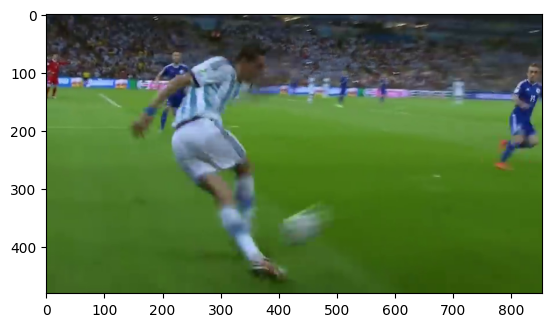

In [3]:
frames = extract_frames('back.mp4')
plt.imshow(frames[30])

In [4]:
magnitude, angle = optical_flow(frames[30], frames[31], **farneback_params)

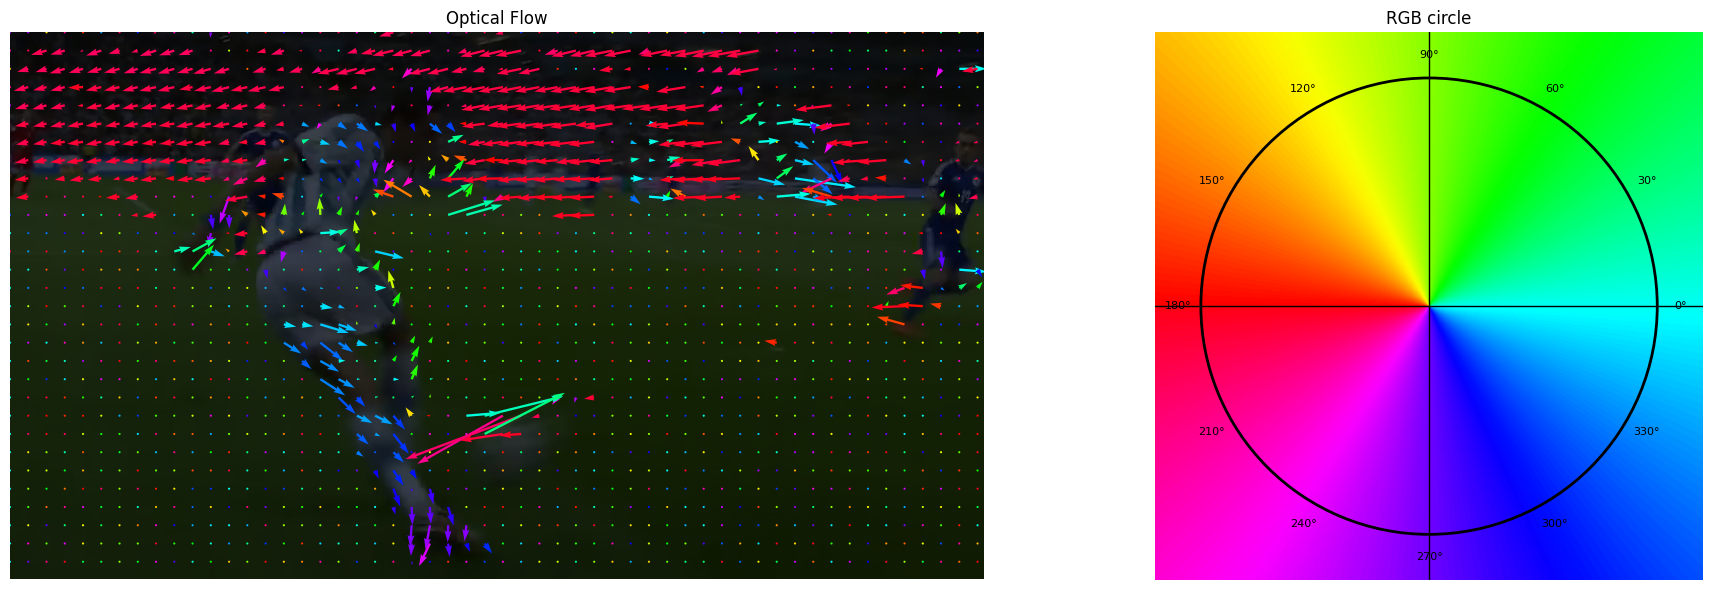

In [5]:
plot_optical_flow(magnitude = magnitude, angle = angle, image = frames[30], plot_type = 'vector')

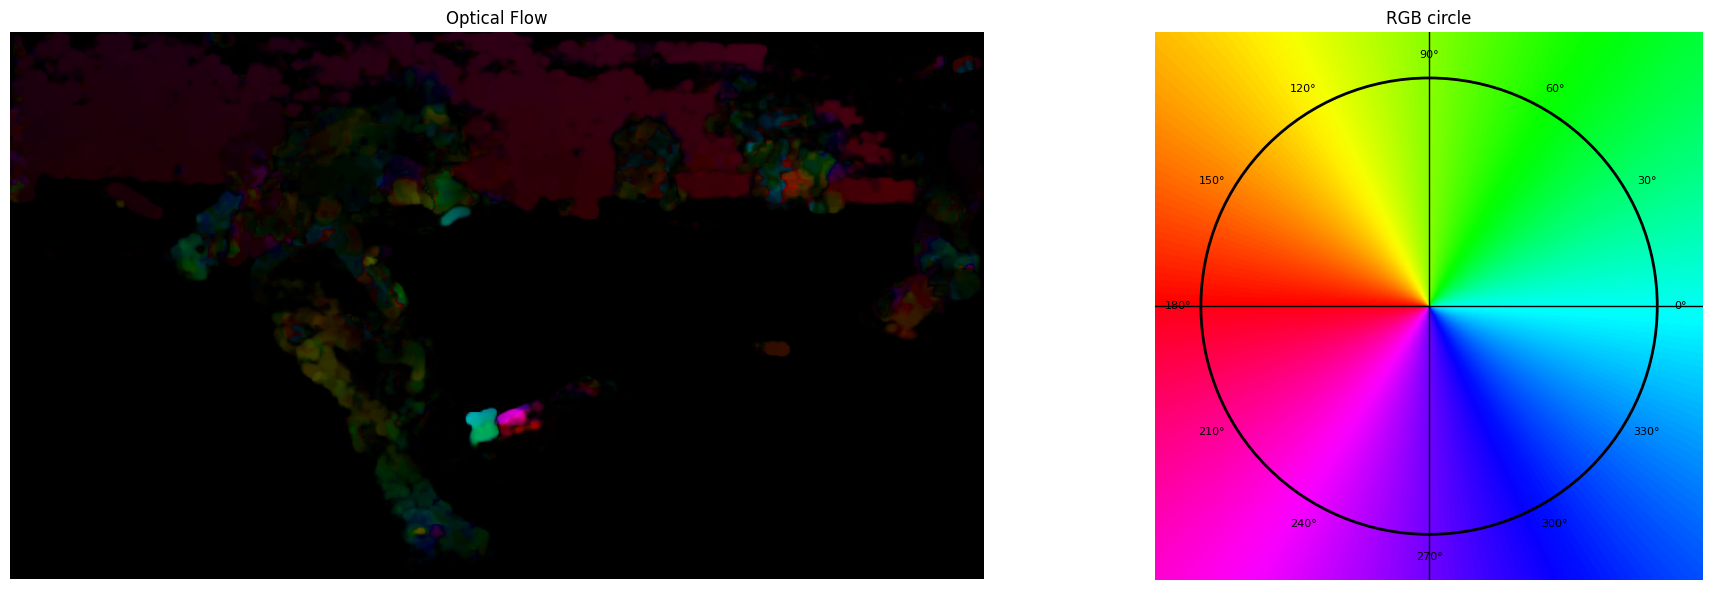

In [6]:
plot_optical_flow(magnitude = magnitude, angle = angle, image = frames[30], plot_type = 'flow')

#### Zadanie 1b
Zbadaj wpływ parametru `winsize` na działanie metody.

In [7]:
winsizes = [1, 3, 5, 11, 15, 21, 31, 51]

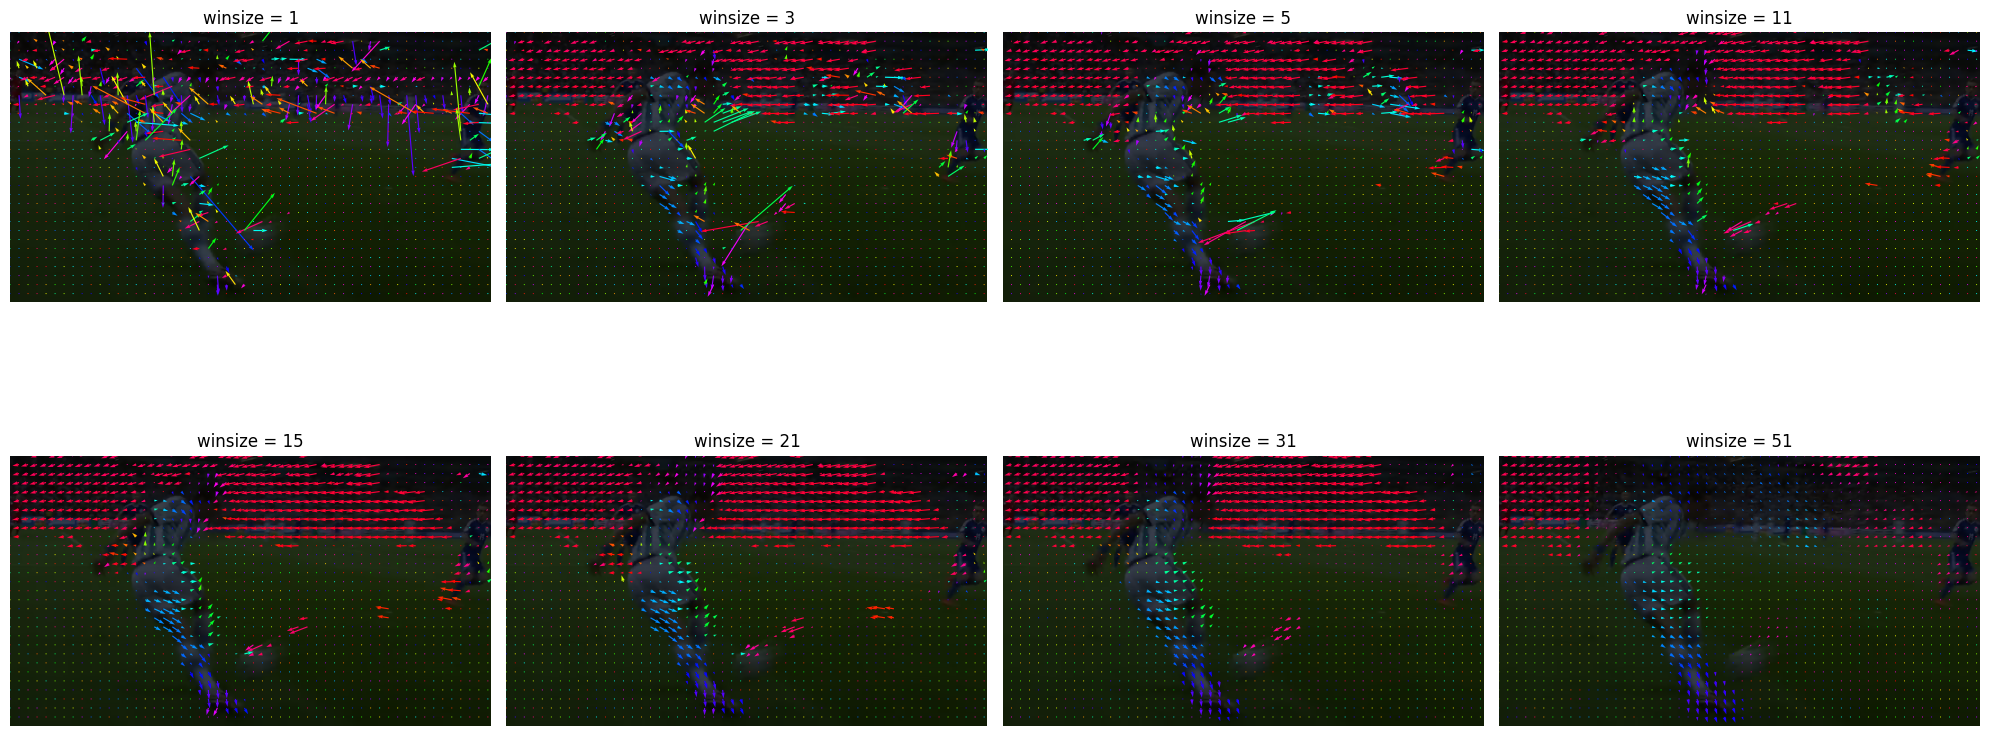

In [8]:
_, axs = plt.subplots(2, 4, figsize = (20, 10))
for i, winsize in enumerate(winsizes):
    params_copy = farneback_params.copy()
    params_copy['winsize'] = winsize
    magnitude, angle = optical_flow(frames[30], frames[31], **params_copy)
    display_optical_flow_no_legend(axs[i // 4, i % 4], magnitude, angle, frames[30])
    axs[i // 4, i % 4].set_title(f'winsize = {winsize}')
plt.tight_layout()
plt.show()

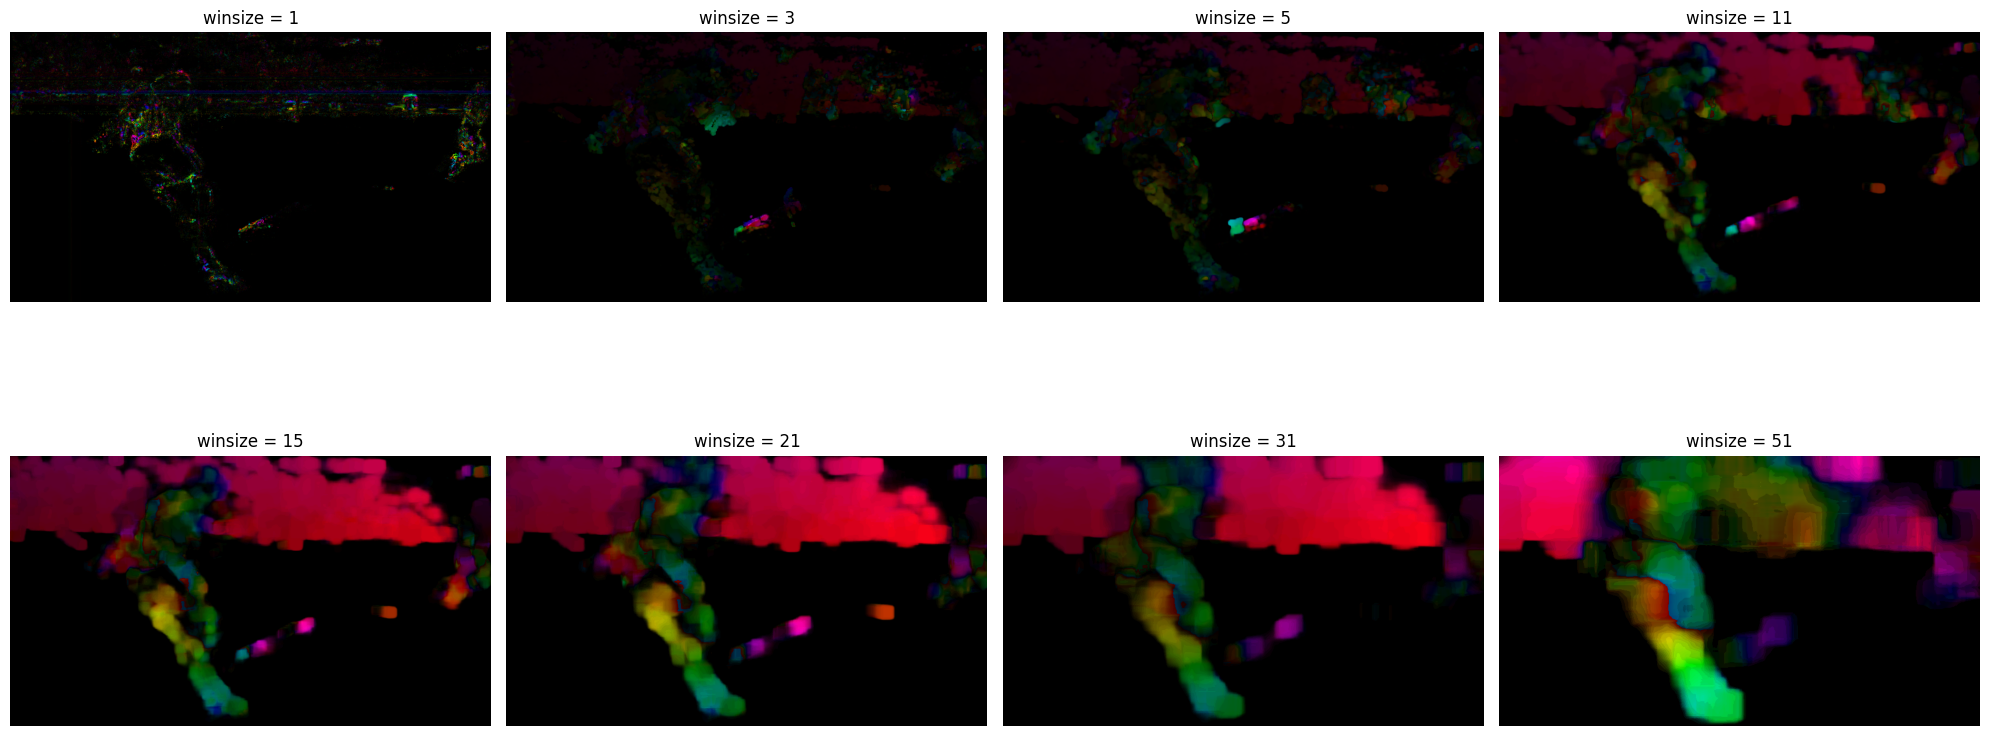

In [9]:
_, axs = plt.subplots(2, 4, figsize = (20, 10))
for i, winsize in enumerate(winsizes):
    params_copy = farneback_params.copy()
    params_copy['winsize'] = winsize
    magnitude, angle = optical_flow(frames[30], frames[31], **params_copy)
    display_optical_flow_no_legend(axs[i // 4, i % 4], magnitude, angle, frames[30], plot_type = 'flow')
    axs[i // 4, i % 4].set_title(f'winsize = {winsize}')
plt.tight_layout()
plt.show()

Komentarz 1:

...

---

### Zadanie 2

Powtórz powyższy eksperyment na materiale `shot.mp4` (przewiń materiał do momentu natychmiast po uderzeniu białej bili, ok. 20-25 klatek; framerate wynosi tu ok. 15fps).  
*Czy algorytm działa tak samo dobrze? Dlaczego? Co jest ograniczeniem metody?*

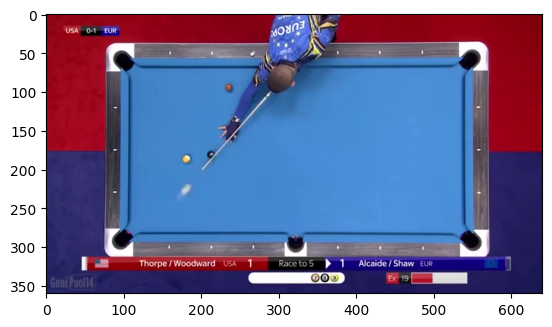

In [10]:
frames_2 = extract_frames('shot.mp4')
plt.imshow(frames_2[21])

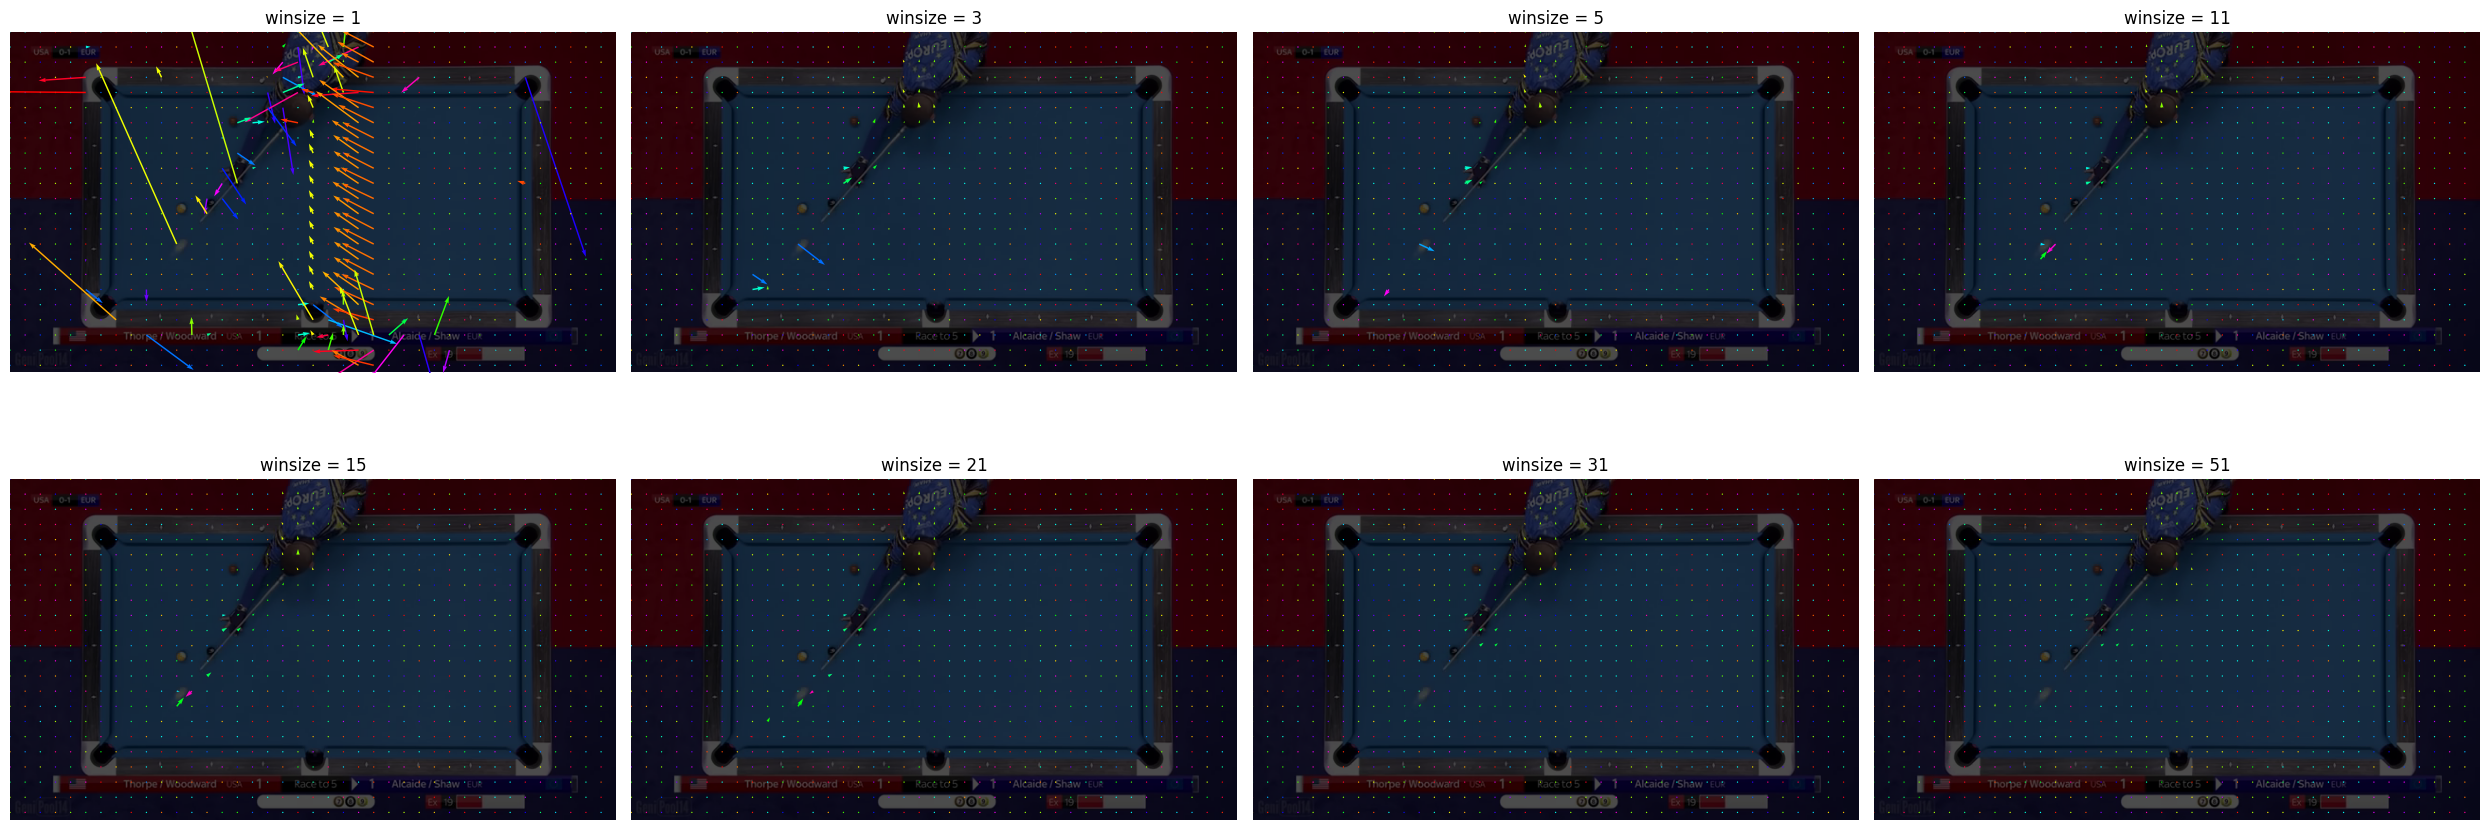

In [14]:
winsizes = [1, 3, 5, 11, 15, 21, 31, 51]
_, axs = plt.subplots(2, 4, figsize = (25, 10))
for i, winsize in enumerate(winsizes):
    params_copy = farneback_params.copy()
    params_copy['winsize'] = winsize
    magnitude2, angle2 = optical_flow(frames_2[21], frames_2[22], **params_copy)
    display_optical_flow_no_legend(axs[i // 4, i % 4], magnitude2, angle2, frames_2[21])
    axs[i // 4, i % 4].set_title(f'winsize = {winsize}')
plt.tight_layout()
plt.show()

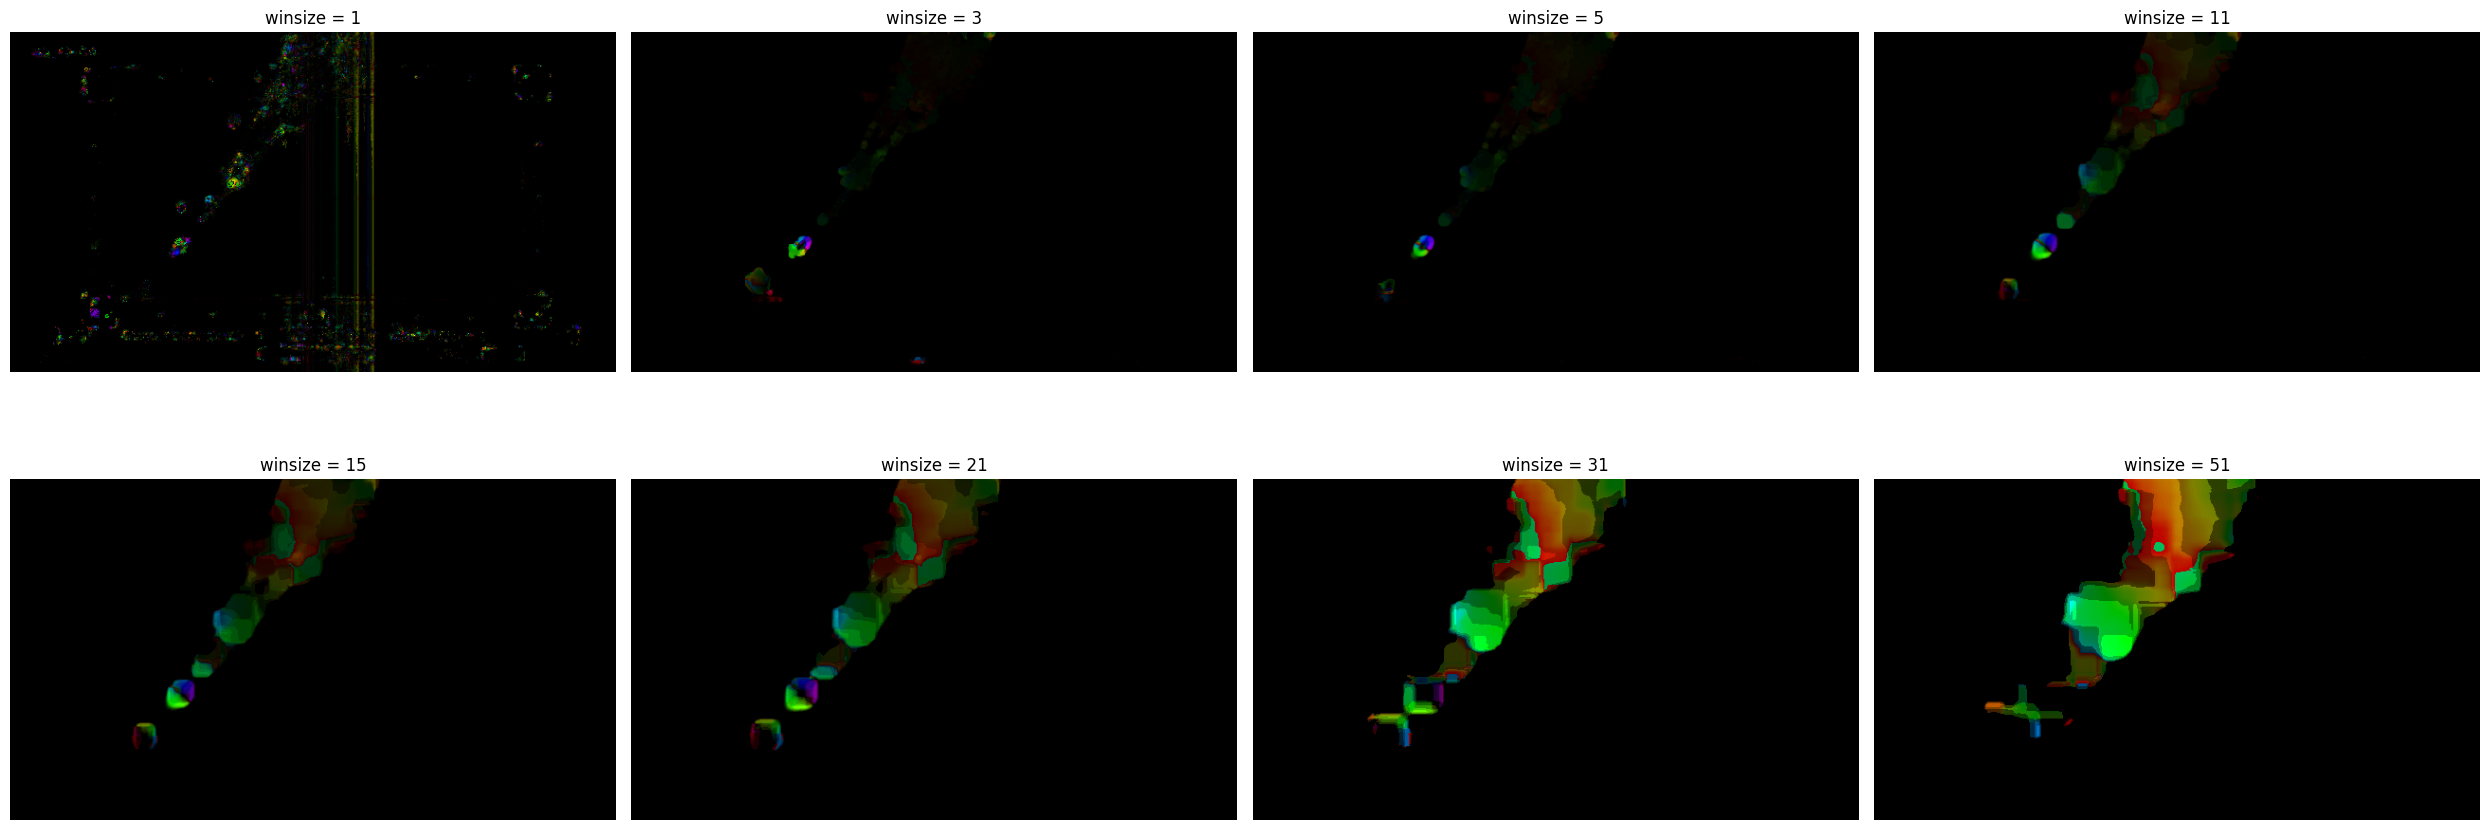

In [15]:
winsizes = [1, 3, 5, 11, 15, 21, 31, 51]
_, axs = plt.subplots(2, 4, figsize = (25, 10))
for i, winsize in enumerate(winsizes):
    params_copy = farneback_params.copy()
    params_copy['winsize'] = winsize
    magnitude2, angle2 = optical_flow(frames_2[21], frames_2[22], **params_copy)
    display_optical_flow_no_legend(axs[i // 4, i % 4], magnitude2, angle2, frames_2[21], plot_type = 'flow')
    axs[i // 4, i % 4].set_title(f'winsize = {winsize}')
plt.tight_layout()
plt.show()

Komentarz 2:

...

### Zadanie dla chętnych

Powróć do takiego przypadku i konfiguracji algorytmu, dla którego uzyskane przez Ciebie wyniki były satysfakcjonujące. Przypomnij sobie zajęcia dotyczące np. segmentacji i wykorzystaj informację o przepływie optycznym do oddzielenia na obrazie obiektów od tła (metoda zupełnie dowolna).